In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit
import random
random.seed(1000)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\LMS-Khatrib\AppData\Local\Temp\ipykernel_13840\3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
test1_df = pd.read_csv('SRER21_dataset_v1.csv', na_values='?').dropna()
train1_df = pd.read_csv('JORN17_dataset_v2.csv', na_values='?').dropna()
test_df = test1_df.reindex(columns = ["OID_", "Id", "gridcode","Shape_Length", "Shape_Area","CH_mean", "ARVI_mean","ARVI_max","ARVI_med","EVI_mean","EVI_max","EVI_med","NDVI_mean","NDVI_max","NDVI_med","SAVI_mean","SAVI_max","SAVI_med", "Veg_class"])
train_df= train1_df.reindex(columns = ["OID_", "Id", "gridcode","Shape_Length", "Shape_Area","CH_mean", "ARVI_mean","ARVI_max","ARVI_med","EVI_mean","EVI_max","EVI_med","NDVI_mean","NDVI_max","NDVI_med","SAVI_mean","SAVI_max","SAVI_med", "Veg_class"])
bigtest1_df = pd.read_csv('SRER21_pred.csv', na_values='?')
bg1 = bigtest1_df.drop(columns=["Veg_class"])
#OID__x,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_max,ARVI_med,EVI_mean,EVI_max,EVI_med,NDVI_mean,NDVI_max,NDVI_med,SAVI_mean,SAVI_max,SAVI_med,Veg_class
bigtest_df = bg1.dropna()
bigtest_df = bigtest_df.reindex(columns = ["OID_", "Id", "gridcode","Shape_Length", "Shape_Area","CH_mean", "ARVI_mean","ARVI_max","ARVI_med","EVI_mean","EVI_max","EVI_med","NDVI_mean","NDVI_max","NDVI_med","SAVI_mean","SAVI_max","SAVI_med", "Veg_class"]).fillna(0)

In [6]:
bigtest_df.shape

(1790829, 19)

In [7]:
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex8.append(test_index)
    testindex9.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.0279404999999997 seconds ---

Accuracy of each fold: 
 [0.6962264150943396, 0.7, 0.7320754716981132, 0.7169811320754716, 0.722117202268431]
Avg accuracy: 0.7134800442272711
Std of accuracy : 
0.013505904994468661

[[ 521  456]
 [ 303 1369]]

              precision    recall  f1-score   support

   non-woody       0.63      0.53      0.58       977
       woody       0.75      0.82      0.78      1672

    accuracy                           0.71      2649
   macro avg       0.69      0.68      0.68      2649
weighted avg       0.71      0.71      0.71      2649

0.5332650972364381
0.81877990430622
0.6322815533980582
0.5785674625208218


In [8]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[ 350 1880]
 [  94 4481]]

              precision    recall  f1-score   support

   non-woody       0.79      0.16      0.26      2230
       woody       0.70      0.98      0.82      4575

    accuracy                           0.71      6805
   macro avg       0.75      0.57      0.54      6805
weighted avg       0.73      0.71      0.64      6805

predicted ['woody' 'woody' 'woody' ... 'woody' 'woody' 'woody']
acc 0.7099191770756796
sens  0.9794535519125683
spec  0.15695067264573992
prec  0.7882882882882883
f1_score  0.2617801047120419


In [9]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted

In [10]:
woodyarea = 0
nonwoodyarea = 0 
totalarea = 0
index = -1
woody = 0
nw = 0
#print(bigtest_df.iat[index,4])
area = bigtest_df["Shape_Area"]
#print(area)

for i in bigtest_df["Veg_class"]:
    index += 1
    if i == "woody":
        totalarea += bigtest_df.iat[index,4]
        woodyarea += bigtest_df.iat[index,4]
        #print(woodyarea)
        woody += 1
    if i == "non-woody":
        totalarea += bigtest_df.iat[index,4]
        nonwoodyarea += bigtest_df.iat[index,4]
        #print(nonwoodyarea)
        nw += 1
print (woodyarea)
print(nonwoodyarea)
print(totalarea)
FWClog = woodyarea / totalarea * 100

19016361.24999288
918896.7700015127
19935258.01999423


In [11]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)


elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 39.6813815 seconds ---

Accuracy of each fold: 
 [0.7320754716981132, 0.7566037735849057, 0.779245283018868, 0.7679245283018868, 0.77882797731569]
Avg accuracy: 0.7629354067838927
Std of accuracy : 
0.017526564791166103

[[ 628  349]
 [ 279 1393]]

              precision    recall  f1-score   support

   non-woody       0.69      0.64      0.67       977
       woody       0.80      0.83      0.82      1672

    accuracy                           0.76      2649
   macro avg       0.75      0.74      0.74      2649
weighted avg       0.76      0.76      0.76      2649

0.6427840327533265
0.8331339712918661
0.6923925027563396
0.6666666666666666


In [12]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[ 887 1343]
 [ 250 4325]]

              precision    recall  f1-score   support

   non-woody       0.78      0.40      0.53      2230
       woody       0.76      0.95      0.84      4575

    accuracy                           0.77      6805
   macro avg       0.77      0.67      0.69      6805
weighted avg       0.77      0.77      0.74      6805

predicted ['woody' 'woody' 'woody' ... 'woody' 'woody' 'woody']
acc 0.7659074210139604
sens  0.9453551912568307
spec  0.3977578475336323
prec  0.7801231310466139
f1_score  0.5268785268785269


In [13]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted


In [14]:
woodyarea = 0
nonwoodyarea = 0 
totalarea = 0
index = -1
woody = 0
nw = 0
#print(bigtest_df.iat[index,4])
area = bigtest_df["Shape_Area"]
#print(area)

for i in bigtest_df["Veg_class"]:
    index += 1
    if i == "woody":
        totalarea += bigtest_df.iat[index,4]
        woodyarea += bigtest_df.iat[index,4]
        #print(woodyarea)
        woody += 1
    if i == "non-woody":
        totalarea += bigtest_df.iat[index,4]
        nonwoodyarea += bigtest_df.iat[index,4]
        #print(nonwoodyarea)
        nw += 1
print (woodyarea)
print(nonwoodyarea)
print(totalarea)
FWClda = woodyarea / totalarea * 100

17250975.109992415
2684282.9100013995
19935258.01999423


In [15]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 80.2423931 seconds ---

Accuracy of each fold: 
 [0.6981132075471698, 0.7226415094339622, 0.6547169811320754, 0.6547169811320754, 0.6805293005671077]
Avg accuracy: 0.6821435959624782
Std of accuracy : 
0.026085067918039904

[[861 116]
 [726 946]]

              precision    recall  f1-score   support

   non-woody       0.54      0.88      0.67       977
       woody       0.89      0.57      0.69      1672

    accuracy                           0.68      2649
   macro avg       0.72      0.72      0.68      2649
weighted avg       0.76      0.68      0.68      2649

0.8812691914022518
0.5657894736842105
0.5425330812854442
0.671606864274571


In [16]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[ 657 1573]
 [ 321 4254]]

              precision    recall  f1-score   support

   non-woody       0.67      0.29      0.41      2230
       woody       0.73      0.93      0.82      4575

    accuracy                           0.72      6805
   macro avg       0.70      0.61      0.61      6805
weighted avg       0.71      0.72      0.68      6805

predicted ['woody' 'woody' 'woody' ... 'woody' 'woody' 'woody']
acc 0.7216752387950037
sens  0.9298360655737705
spec  0.2946188340807175
prec  0.6717791411042945
f1_score  0.40960099750623435


In [17]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted

In [18]:
woodyarea = 0
nonwoodyarea = 0 
totalarea = 0
index = -1
woody = 0
nw = 0
#print(bigtest_df.iat[index,4])
area = bigtest_df["Shape_Area"]
#print(area)

for i in bigtest_df["Veg_class"]:
    index += 1
    if i == "woody":
        totalarea += bigtest_df.iat[index,4]
        woodyarea += bigtest_df.iat[index,4]
        #print(woodyarea)
        woody += 1
    if i == "non-woody":
        totalarea += bigtest_df.iat[index,4]
        nonwoodyarea += bigtest_df.iat[index,4]
        #print(nonwoodyarea)
        nw += 1
print (woodyarea)
print(nonwoodyarea)
print(totalarea)
FWCqda = woodyarea / totalarea * 100

15795229.349988079
4140028.6700059636
19935258.01999423


#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [19]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.72641509 0.70943396 0.72641509 0.73773585 0.72022684]

Avg accuracy: 0.7240453686200377

K=2

Accuracy of each fold: 
 [0.68867925 0.69811321 0.70754717 0.68679245 0.6899811 ]

Avg accuracy: 0.6942226343760032

K=3

Accuracy of each fold: 
 [0.72075472 0.73773585 0.76981132 0.73396226 0.74858223]

Avg accuracy: 0.742169276313443

K=4

Accuracy of each fold: 
 [0.70754717 0.75471698 0.74339623 0.70188679 0.73913043]

Avg accuracy: 0.7293355209187858

K=5

Accuracy of each fold: 
 [0.73396226 0.75471698 0.77735849 0.72830189 0.75803403]

Avg accuracy: 0.7504747298213076

K=6

Accuracy of each fold: 
 [0.72830189 0.76037736 0.77924528 0.7245283  0.731569  ]

Avg accuracy: 0.744804365659664

K=7

Accuracy of each fold: 
 [0.73773585 0.75471698 0.77735849 0.72830189 0.76181474]

Avg accuracy: 0.7519855904697363

K=8

Accuracy of each fold: 
 [0.73396226 0.75471698 0.76981132 0.72264151 0.7637051 ]

Avg accuracy: 0.7489674358882905

K=9

Accuracy of each fold

In [20]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 122.7013647 seconds ---

Accuracy of each fold: 
 [0.7433962264150943, 0.7528301886792453, 0.7830188679245284, 0.730188679245283, 0.776937618147448]
Avg accuracy: 0.7572743160823198
Std of accuracy : 
0.019977040630257493

[[ 614  363]
 [ 280 1392]]

              precision    recall  f1-score   support

   non-woody       0.69      0.63      0.66       977
       woody       0.79      0.83      0.81      1672

    accuracy                           0.76      2649
   macro avg       0.74      0.73      0.73      2649
weighted avg       0.75      0.76      0.75      2649

0.6284544524053224
0.8325358851674641
0.6868008948545862
0.6563335114911812


In [21]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[ 403 1827]
 [ 135 4440]]

              precision    recall  f1-score   support

   non-woody       0.75      0.18      0.29      2230
       woody       0.71      0.97      0.82      4575

    accuracy                           0.71      6805
   macro avg       0.73      0.58      0.56      6805
weighted avg       0.72      0.71      0.65      6805

predicted ['woody' 'woody' 'woody' ... 'woody' 'woody' 'woody']
acc 0.7116825863335783
sens  0.9704918032786886
spec  0.18071748878923766
prec  0.7490706319702602
f1_score  0.2911849710982659


In [22]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted

In [23]:
woodyarea = 0
nonwoodyarea = 0 
totalarea = 0
index = -1
woody = 0
nw = 0
#print(bigtest_df.iat[index,4])
area = bigtest_df["Shape_Area"]
#print(area)

for i in bigtest_df["Veg_class"]:
    index += 1
    if i == "woody":
        totalarea += bigtest_df.iat[index,4]
        woodyarea += bigtest_df.iat[index,4]
        #print(woodyarea)
        woody += 1
    if i == "non-woody":
        totalarea += bigtest_df.iat[index,4]
        nonwoodyarea += bigtest_df.iat[index,4]
        #print(nonwoodyarea)
        nw += 1
print (woodyarea)
print(nonwoodyarea)
print(totalarea)
FWCknn = woodyarea / totalarea * 100

17530923.729992256
2404334.290001306
19935258.01999423


In [24]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.713480,0.013506,0.533265,0.818780,0.632282,0.578567,0.027940
LDA,0.762935,0.017527,0.642784,0.833134,0.692393,0.666667,39.681382
QDA,0.682144,0.026085,0.881269,0.565789,0.542533,0.671607,80.242393
KNN-CV,0.757274,0.019977,0.628454,0.832536,0.686801,0.656334,122.701365


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.7134800442272711, 0.7629354067838927, 0.6821435959624782, 0.7572743160823198]
Sen[0.5332650972364381, 0.6427840327533265, 0.8812691914022518, 0.6284544524053224]
Spec[0.81877990430622, 0.8331339712918661, 0.5657894736842105, 0.8325358851674641]
P[0.6322815533980582, 0.6923925027563396, 0.5425330812854442, 0.6868008948545862]
F1[0.5785674625208218, 0.6666666666666666, 0.671606864274571, 0.6563335114911812]


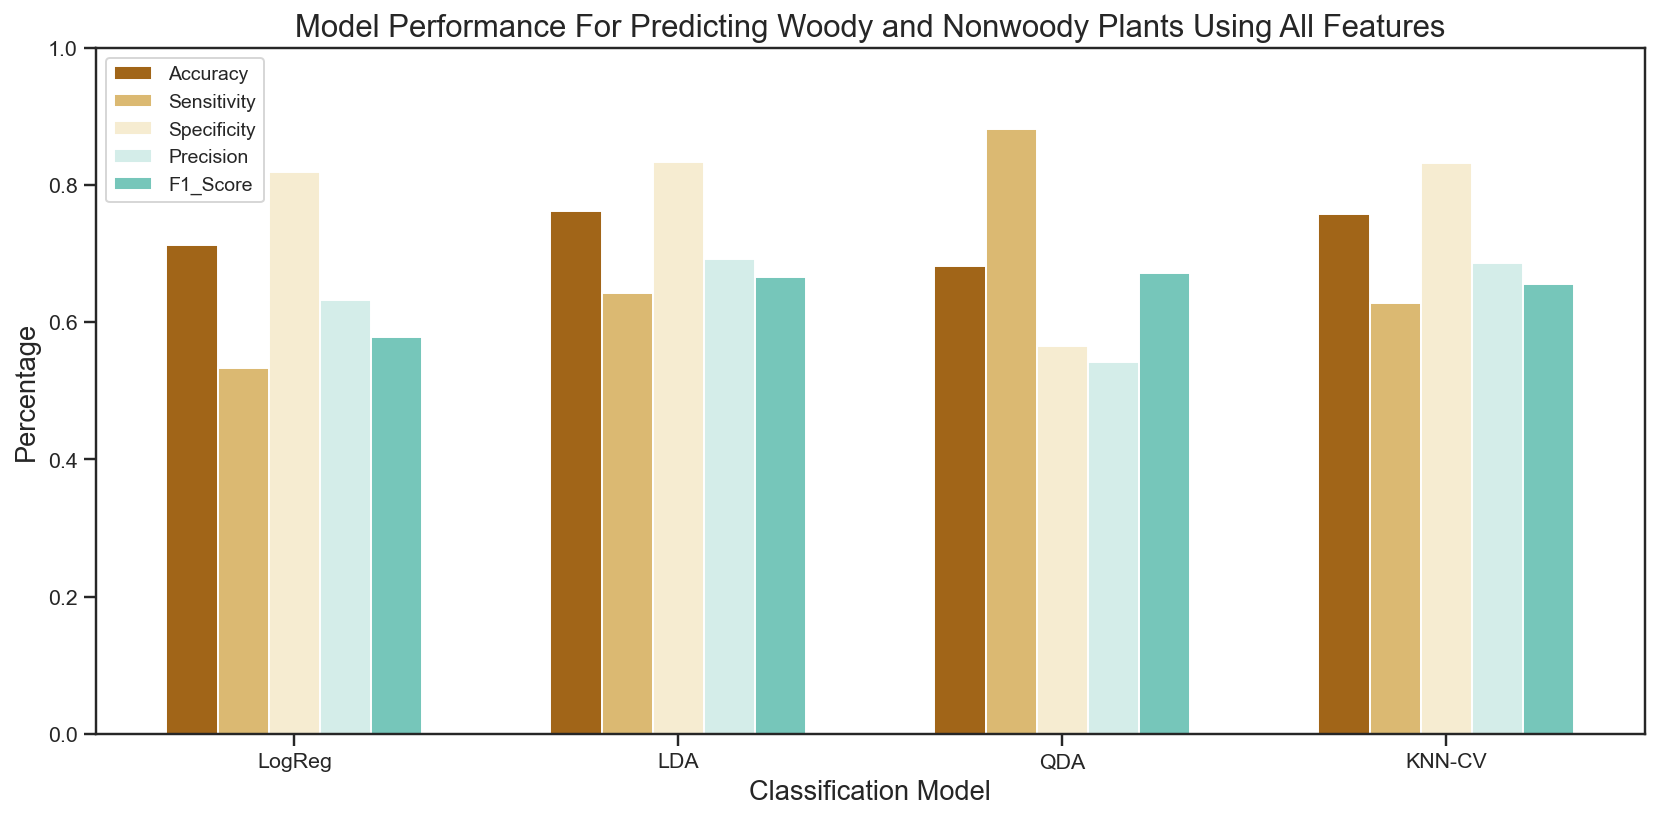

In [25]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

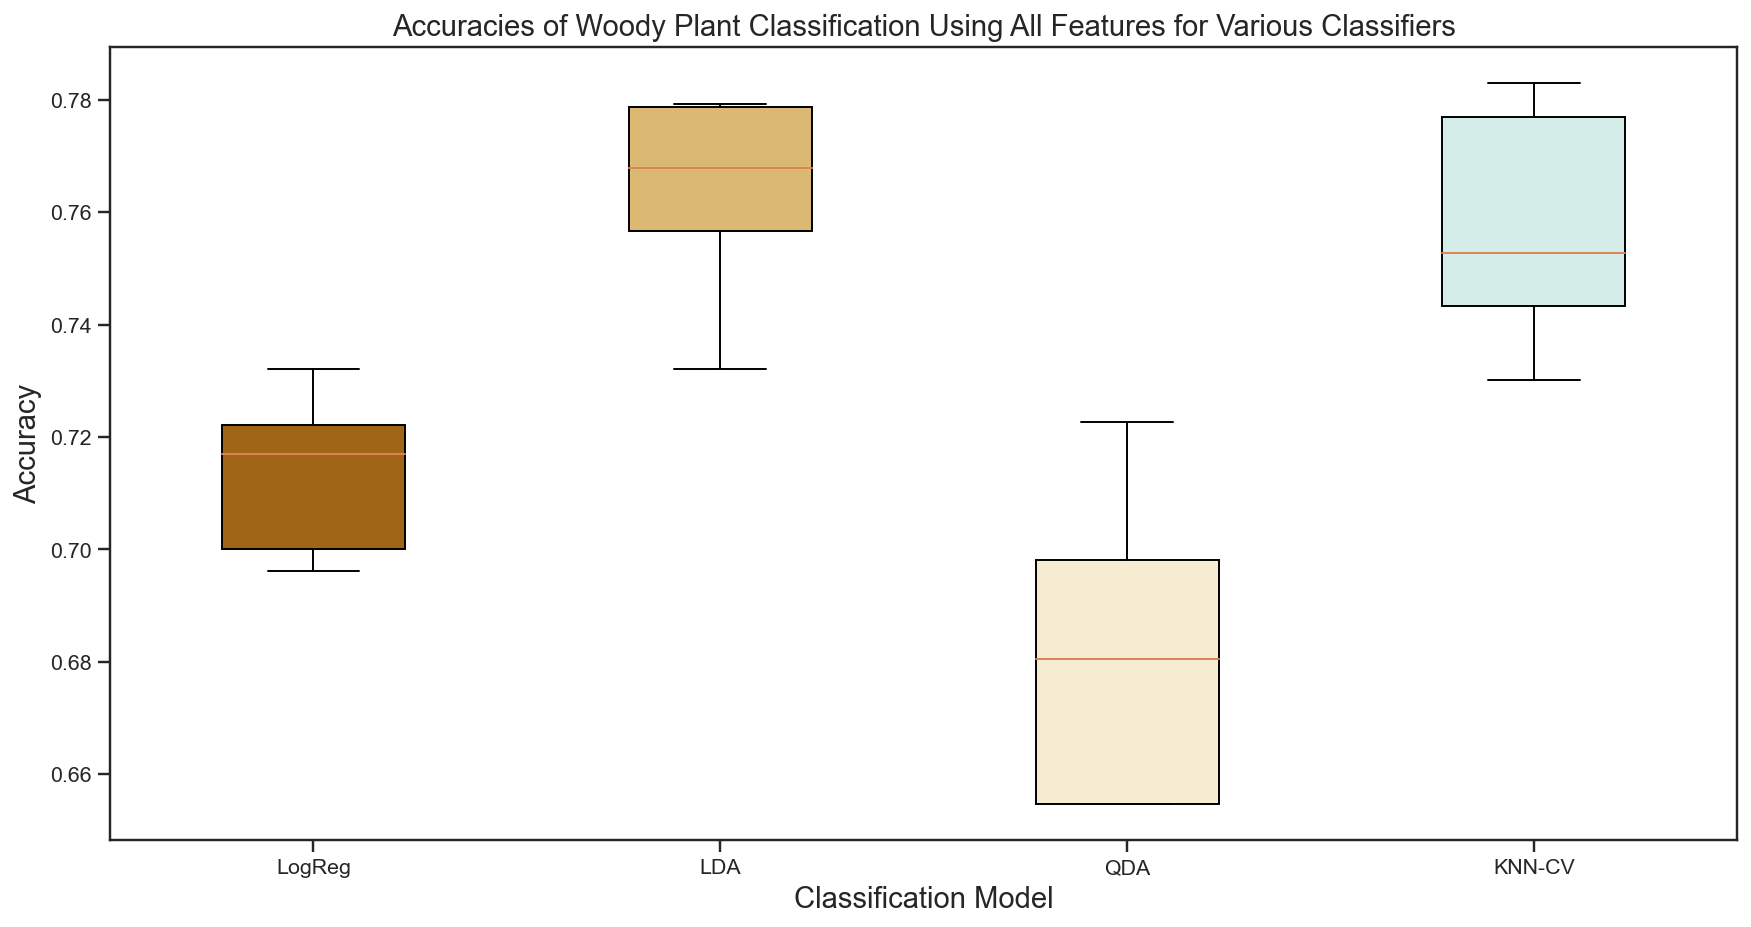

In [26]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of Woody Plant Classification Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()
colors = sns.color_palette("BrBG")

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [27]:
#print("Log reg act: " + str())
print("Log reg pred: " + str(FWClog))
#print("QDA act: " + str(needed2))
print("QDA pred: " + str(FWCqda))
#print("LDA act: " + str(needed3))
print("LDA pred: " + str(FWClda))
#print("KNN act: " + str(needed4))
print("KNN pred: " +str(FWCknn))

Log reg pred: 95.39059504983716
QDA pred: 79.23263061930838
LDA pred: 86.53499790517087
KNN pred: 87.93928682743646
